# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/'
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataPath = 'data/'

In [2]:
import pickle
import pandas as pd

with open(dataPath + '2022_02_11/recipes_valid_0.pkl', 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())
print(len(pklData))

Index(['title', 'ingredients', 'instructions'], dtype='object')
100000


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
!pip install word2vec

In [4]:
from ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor(dataPath + '/vocab.bin')

out = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [5]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from ReciMeEncoder import ReciMeEncoder, RmeParameters

# Import custom helper functions
from networkUtils import DataBuilder, CustomLoss, standardize_data, sparse_batch_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Setup Datasets + Hyperparameters

In [6]:
# One hot encoding without embedding and using sparse frame
train_data, test_data, scaler =  standardize_data(out)
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data, standardizer=scaler)
testdata_set=DataBuilder(test_data, standardizer=scaler)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [7]:
testdata_set.x.shape[1]

6360

In [8]:
params = RmeParameters(testdata_set.x.shape[1], 8192, 4096, 2048, 512)

model = ReciMeEncoder(params).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_mse = CustomLoss()

### Train Model

In [9]:
epochs = 50
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_MSE = 0
    train_loss_KLD = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        train_loss_MSE += loss_MSE
        train_loss_KLD += loss_KLD
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss / len(trainloader.dataset), 
            train_loss_MSE / len(trainloader.dataset), 
            train_loss_KLD / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))


In [11]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        test_loss_MSE = 0
        test_loss_KLD = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
            test_loss_MSE += loss_MSE
            test_loss_KLD += loss_KLD
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average training loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset), 
                test_loss_MSE / len(testloader.dataset), 
                test_loss_KLD / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [12]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

====> Epoch: 5 Average training loss: 0.03682, MSE: 0.00841, KLD: 0.02841
====> Epoch: 5 Average training loss: 0.0355, MSE: 0.0085, KLD: 0.0269
====> Epoch: 10 Average training loss: 0.02297, MSE: 0.00841, KLD: 0.01456
====> Epoch: 10 Average training loss: 0.0232, MSE: 0.0085, KLD: 0.0146
====> Epoch: 15 Average training loss: 0.01735, MSE: 0.00841, KLD: 0.00893
====> Epoch: 15 Average training loss: 0.0177, MSE: 0.0085, KLD: 0.0092
====> Epoch: 20 Average training loss: 0.01417, MSE: 0.00841, KLD: 0.00575
====> Epoch: 20 Average training loss: 0.0147, MSE: 0.0085, KLD: 0.0061
====> Epoch: 25 Average training loss: 0.01224, MSE: 0.00841, KLD: 0.00382
====> Epoch: 25 Average training loss: 0.0127, MSE: 0.0085, KLD: 0.0042
====> Epoch: 30 Average training loss: 0.01102, MSE: 0.00841, KLD: 0.00261
====> Epoch: 30 Average training loss: 0.0115, MSE: 0.0085, KLD: 0.0029
====> Epoch: 35 Average training loss: 0.01023, MSE: 0.00841, KLD: 0.00181
====> Epoch: 35 Average training loss: 0.0106

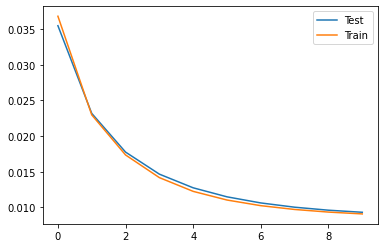

In [13]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [14]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        break

In [15]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [16]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data)

In [17]:
print(fake_data.shape)
print(type(fake_data))

(20, 6360)
<class 'numpy.ndarray'>


In [18]:
def inverseOneHotEncoding(encoded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in encoded:
        rowTransformed = np.reshape(row, (20,-1))
        rowString = []
        indexTransformed = np.argmax(rowTransformed, axis=1) + 1
        for index in indexTransformed:
            if (index in dictionary.values()):
                rowString.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                rowString.append("")
        output.append(rowString)
    return np.array(output)

In [19]:
def inverseEmbedding(embedded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in embedded:
        outputRows = []
        for rowTransformed in np.reshape(row, (20,-1)):
            rowTransformed = torch.Tensor(rowTransformed)
            distance = torch.norm(preprocessor.emb.weight.data - rowTransformed, dim=1)
            nearest = torch.argmin(distance)
            index = nearest.item()
            if index:
                outputRows.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                outputRows.append("")
        output.append(outputRows)

    return np.array(output)

In [20]:
def decodeOutput(output: np.ndarray):
    # Split output into amounts, units and ingredients 
    amounts = output[:, :20]
    amountColumns = ['amount_' + str(sub) for sub in list(range(0,20))]
    units = output[:, 20:len(preprocessor.unitDict)*20+20]
    unitColumns = ['unit_' + str(sub) for sub in list(range(0,20))]
    ingredients = output[:, len(preprocessor.unitDict)*20+20:]
    ingredientColumns = ['ingredient_' + str(sub) for sub in list(range(0,20))]
    unitsDecoded = inverseOneHotEncoding(units, preprocessor.unitDict)
    ingredientsDecoded = inverseEmbedding(ingredients, preprocessor.ingredientDict)
    outputFrame = []
    for index in range(len(amounts)):
        array = np.stack((amounts[index], unitsDecoded[index], ingredientsDecoded[index]),axis=1)
        outputFrame.append(pd.DataFrame(array, columns=["amount", "unit", "ingredient"]))
    return outputFrame

df = decodeOutput(fake_data)
df[0]

,amount,unit,ingredient
0,14.512605,,</s>
1,4.1505537,,</s>
2,4.859861,,</s>
3,5.5665226,cup,</s>
4,4.3212204,,</s>
5,3.545336,,
6,4.467539,,
7,2.66823,,
8,2.3120317,cup,
9,1.4997869,cup,


In [21]:
data = pklData[:1]['ingredients']

dataEmbedded = np.array(preprocessor.preProcessInput(data))

dataReconverted = decodeOutput(dataEmbedded)
pd.concat([dataReconverted[0], data[0].add_prefix("orig_")], axis=1)

,amount,unit,ingredient,orig_amount,orig_unit,orig_ingredient
0,1.0,,elbow_macaroni,1.00,,elbow macaroni
1,1.0,,cheese,1.00,,american cheese
2,0.5,,celery,0.50,,celery
3,0.5,,green_peppers,0.50,,green peppers
4,3.0,tablespoon,pimentos,3.00,tablespoon,pimentos
5,0.5,,mayonnaise,0.50,,mayonnaise
6,1.0,tablespoon,vinegar,1.00,tablespoon,vinegar
7,0.75,teaspoon,salt,0.75,teaspoon,salt
8,0.5,teaspoon,dill_weed,0.50,teaspoon,dry dill weed
9,0.0,,,NaN,NaN,NaN


In [22]:
string = "dry dill weed"
name_words = string.lower().split(' ')
for i in range(len(name_words)):
    print('_'.join(name_words[i:]))

dry_dill_weed
dill_weed
weed


In [23]:
embeddings = torch.nn.Embedding(1000, 100)
my_sample = torch.randn(1, 100)
distance = torch.norm(embeddings.weight.data - my_sample, dim=1)
nearest = torch.argmin(distance)
print(my_sample.shape)
print(embeddings.weight.data.shape)

torch.Size([1, 100])
torch.Size([1000, 100])


In [24]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped_cols)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

NameError: ignored

In [ ]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)